# Assignment2 -Group: 33
Tutors:  

 - Dongang Wang
 
Group members:

- Shengyuan Sun 460257820
- Rui Chen 470111585

##Abstract

describe the rest of your report

## Introduction

## Previous work

should present the dataset that you chose, discuss its relevance
in diverse applications, and give an overview of the methods you used.


listing successful techniques on
similar datasets

## Methods

### Connect PyDrive

Run the code below and follow the instruction to get the authentication from google drive.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Load dataset
The dataset we use is **SVHN**. SVHN provides two formats of train and test data. We choose format 2 as the input of our data source.
The dataset has been shared in a drive directory with its **id = 1rcC3ZHrYF9jLAZwRx-XnQg7d-Hgp3OYf**
 - Input : ID of dataset directory
 - Output: Two objects of  files ("train_set" and "test_set")

In [17]:
# List the files in the shared directory
files = drive.ListFile({'q': "'1rcC3ZHrYF9jLAZwRx-XnQg7d-Hgp3OYf' in parents and trashed=false"}).GetList()
for file in files:
    print('File_name: %s, File_id: %s' % (file['title'], file['id']))

File_name: test_32x32.mat, File_id: 1u6CD2TBjcbnBRGFx2ovaMbxi9LfjQ-Df
File_name: train_32x32.mat, File_id: 1gYfvRD9LHbleNNebLHkUE4S2N7NoBzcs


In [0]:
# Copy the data files to Colab VM
fetch_test_file = drive.CreateFile({'id': '1u6CD2TBjcbnBRGFx2ovaMbxi9LfjQ-Df'})
fetch_test_file.GetContentFile('test_32x32.mat')
fetch_train_file = drive.CreateFile({"id":"1gYfvRD9LHbleNNebLHkUE4S2N7NoBzcs"})
fetch_train_file.GetContentFile("train_32x32.mat")

In [13]:
# Display the files in Colab VM
ls

datalab/  test_32x32.mat  train_32x32.mat


In [0]:
# Load the files
from scipy.io import loadmat as load
train_set = load("train_32x32.mat")
test_set = load("test_32x32")

### Method1 ---SGD

#### Introduction

Explain the theory behind each of
them and discuss your design choices

#### Preprocessing 

In [0]:
# Import modules
from sklearn import preprocessing
import numpy as np
import gc

# Format the training and testing set
train_X = train_set["X"].T
train_y = train_set["y"]
test_X = test_set["X"].T
test_y = test_set["y"]
# Flat features to one vectors
temp = []
for i in train_X:
    temp.append(i.flatten())
train_X = None
gc.collect()
train_X = np.array(temp, dtype="float")
train_y = np.ravel(train_y)

temp = []
for i in test_X:
    temp.append(i.flatten())
test_X = None
gc.collect()
test_X = np.array(temp, dtype="float")
test_y = np.ravel(test_y)
# Normalization
train_X = preprocessing.scale(train_X)
test_X = preprocessing.scale(test_X)

In [0]:


#PCA part
train_path = "./dataset/train_32x32.mat"
data = scio.loadmat(train_path)

train_X = data["X"]
train_y = data["y"]
train_X = train_X.T
print(train_X.shape)
print(train_y.shape)

tmp = []
for row in train_X:
    tmp.append(row.flatten())
# release training set memory
train_X = None
gc.collect()

train_X = np.array(tmp)
tmp = None

train_X = train_X - train_X.mean(axis=0)
train_X.shape

# PCA decrease the dimension of the training set into d dimensions.
# d is a configurable variable (hyperparameter)
# In this case d = 50.
d = 50
pca = PCA(n_components=d)
start = time.time()
train_X = pca.fit(train_X).transform(train_X)
end = time.time()
print("shape: {}".format(str(train_X.shape)))
print("time consumption: {}s".format(end-start))
dataset = np.hstack((train_X,train_y))


#print(np.shape(train_y))

def train_test_split_10(train_X, train_y,k):
    num_of_examples = len(train_X)
    start_jump = (num_of_examples//10)*k
    end_jump = (num_of_examples//10)*(k+1)
    X_train=[]
    y_train=[]
    X_test=[]
    y_test=[]
    for i in range(len(train_X)):
        if i<=start_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        elif i>end_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        else:
            X_test.append(train_X[i])
            y_test.append(train_y[i])

    return X_train,X_test,y_train,y_test

X_train, X_test, y_train, y_test =  train_test_split_10(train_X, train_y,0)
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(73257, 3, 32, 32)
(73257, 1)
shape: (73257, 50)
time consumption: 30.915773630142212s
(65932, 50)
(65932, 1)
(7325, 50)
(7325, 1)


In [4]:
!free

              total        used        free      shared  buff/cache   available
Mem:       13341832     6828476     5360384      253924     1152972     6052656
Swap:             0           0           0


#### Build dimensionality reduction(PCA) pipeline and GridSearchCV

In [0]:
# import modules
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline([('dim_reduction',PCA()),('classifier',SGDClassifier(alpha=0.001, shuffle=True, verbose=0,\
                    n_jobs=4, random_state=None, learning_rate='optimal'))])

# set turing parameter
TARGET_DIMENSION = [50,100]
LOSS_FUNCTION = ["hinge", "log"]
PENALTY = ["l2","l1"]
param_grid = [
    {
        "dim_reduction__n_components":TARGET_DIMENSION,
        "classifier__loss":LOSS_FUNCTION,
        "classifier__penalty":PENALTY
    }
]
grid = GridSearchCV(pipe, cv=10, param_grid=param_grid, n_jobs=2,scoring="accuracy")

In [17]:
grid.fit(train_X, train_y)

OSError: ignored

In [22]:
grid.grid_scores_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.20196, std: 0.00293, params: {'classifier__loss': 'hinge', 'classifier__penalty': 'l2', 'dim_reduction__n_components': 50},
 mean: 0.20720, std: 0.00263, params: {'classifier__loss': 'hinge', 'classifier__penalty': 'l2', 'dim_reduction__n_components': 100}]

####machine learning techniques

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
y_train=np.array(y_train)
y_test = np.array(y_test)
X_train_temp=np.array(X_train)
X_train_temp=X_train_temp.reshape(X_train_temp.shape[0],-1)
X_test_temp=np.array(X_test)
X_test_temp=X_test_temp.reshape(X_test_temp.shape[0],-1)
# train_data_GCN,train_labels,test_data_GCN,test_labels
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, shuffle=True, verbose=0,\
                    n_jobs=4, random_state=None, learning_rate='optimal')
clf.fit(X_train_temp, y_train)
train_prediction = clf.predict(X_train_temp)
valid_prediction = clf.predict(X_test_temp)

print('Training score is', clf.score(X_train_temp, y_train))
print('Validation score is', clf.score(X_test_temp, y_test))
print(type(y_train))
print(type(train_prediction))
print('Classification report of training data:\n', classification_report(y_train, train_prediction))
print('Confusion Matrix of training data:\n', confusion_matrix(y_train, train_prediction))

print('Classification report of validation data:\n', classification_report(y_test, valid_prediction))
print('Confusion Matrix of validation data:\n', confusion_matrix(y_test, valid_prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training score is 0.10894558029484924
Validation score is 0.10853242320819112
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Classification report of training data:
              precision    recall  f1-score   support

          1       0.27      0.08      0.13     12457
          2       0.15      0.20      0.17      9554
          3       0.13      0.14      0.14      7667
          4       0.11      0.08      0.09      6671
          5       0.14      0.03      0.05      6181
          6       0.11      0.05      0.06      5166
          7       0.07      0.05      0.06      5068
          8       0.10      0.03      0.05      4530
          9       0.05      0.03      0.04      4204
         10       0.07      0.38      0.11      4434

avg / total       0.14      0.11      0.10     65932

Confusion Matrix of training data:
 [[1022 1946 1737 1036  185  242  794  244  427 4824]
 [ 392 1910 1275  930   86  272  545  111  328 3705]
 [ 409 1268 1060  557   97  236  411  268  340 3021]

###Method2---random forest

####introduction

####preprocessing

In [0]:
import scipy.io as scio
from sklearn.decomposition import PCA
import numpy as np
import time
import gc

In [0]:
#PCA part
train_path = "./dataset/train_32x32.mat"
data = scio.loadmat(train_path)

train_X = data["X"]
train_y = data["y"]
train_X = train_X.T
print(train_X.shape)
print(train_y.shape)

tmp = []
for row in train_X:
    tmp.append(row.flatten())
# release training set memory
train_X = None
gc.collect()

train_X = np.array(tmp)
tmp = None

train_X = train_X - train_X.mean(axis=0)
train_X.shape

# PCA decrease the dimension of the training set into d dimensions.
# d is a configurable variable (hyperparameter)
# In this case d = 50.
d = 50
pca = PCA(n_components=d)
start = time.time()
train_X = pca.fit(train_X).transform(train_X)
end = time.time()
print("shape: {}".format(str(train_X.shape)))
print("time consumption: {}s".format(end-start))
dataset = np.hstack((train_X,train_y))

(73257, 3, 32, 32)
(73257, 1)
shape: (73257, 50)
time consumption: 33.56474757194519s


####machine learning techniques

In [0]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

In [0]:
X_train, X_test, y_train, y_test =  train_test_split_10(train_X, train_y,0)
y_train_num=[]
for i in range(len(y_train)):
  label = y_train[i][0]
  #print(label)
  y_train_num.append(label)
y_train=np.array(y_train_num)

y_test_num=[]
for i in range(len(y_test)):
  label = y_test[i][0]
  #print(label)
  y_test_num.append(label)
y_test=np.array(y_test_num)

print(y_train.shape)
print(y_test.shape)

rf0 = RandomForestClassifier(oob_score=True, random_state=10)  
rf0.fit(X_train,y_train)  
print (rf0.oob_score_)  
y_predprob = rf0.predict_proba(X_test)

#print(np.shape(y_test))
#print(np.shape(y_predprob))

score = cross_val_score(rf0, train_X, train_y, cv=10, scoring='accuracy').mean()
print('Validation score is', score)

(65932, 50)
(65932, 1)
(7325, 50)
(7325, 1)
(65932,)
(7325,)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


0.34664502821088394


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/skle

Validation score is 0.4533216974125643


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


对n_estimators进行网格搜索

In [0]:
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.36991, std: 0.00287, params: {'n_estimators': 10},
  mean: 0.37587, std: 0.00052, params: {'n_estimators': 20},
  mean: 0.37942, std: 0.00230, params: {'n_estimators': 30},
  mean: 0.38013, std: 0.00242, params: {'n_estimators': 40},
  mean: 0.38039, std: 0.00294, params: {'n_estimators': 50},
  mean: 0.37977, std: 0.00261, params: {'n_estimators': 60},
  mean: 0.38004, std: 0.00207, params: {'n_estimators': 70}],
 {'n_estimators': 50},
 0.38039191894679364)

得到了最佳的弱学习器迭代次数，接着我们对决策树最大深度max_depth和内部节点再划分所需最小样本数min_samples_split进行网格搜索

In [0]:
start = time.time()
param_test2= {'max_depth':range(3,14,2), 'min_samples_split':range(50,201,20)}  
gsearch2= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 50,  
                                 min_samples_leaf=20,max_features='sqrt' ,oob_score=True,random_state=10),  
   param_grid = param_test2,scoring='accuracy',iid=False, cv=5)  
gsearch2.fit(X_train,y_train)  
gsearch2.grid_scores_,gsearch2.best_params_, gsearch2.best_score_  

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.23245, std: 0.00245, params: {'max_depth': 3, 'min_samples_split': 50},
  mean: 0.23245, std: 0.00245, params: {'max_depth': 3, 'min_samples_split': 70},
  mean: 0.23245, std: 0.00245, params: {'max_depth': 3, 'min_samples_split': 90},
  mean: 0.23245, std: 0.00245, params: {'max_depth': 3, 'min_samples_split': 110},
  mean: 0.23245, std: 0.00245, params: {'max_depth': 3, 'min_samples_split': 130},
  mean: 0.23245, std: 0.00245, params: {'max_depth': 3, 'min_samples_split': 150},
  mean: 0.23245, std: 0.00245, params: {'max_depth': 3, 'min_samples_split': 170},
  mean: 0.23245, std: 0.00245, params: {'max_depth': 3, 'min_samples_split': 190},
  mean: 0.29547, std: 0.00228, params: {'max_depth': 5, 'min_samples_split': 50},
  mean: 0.29439, std: 0.00210, params: {'max_depth': 5, 'min_samples_split': 70},
  mean: 0.29468, std: 0.00225, params: {'max_depth': 5, 'min_samples_split': 90},
  mean: 0.29435, std: 0.00318, params: {'max_depth': 5, 'min_samples_split': 110},
  mean: 0.

对最大特征数max_features做调参

取了三个最优参数，看看现在模型的袋外分数

In [0]:
rf1= RandomForestClassifier(n_estimators= 50, max_depth=13, min_samples_split=50,  
                                 min_samples_leaf=20,max_features='sqrt' ,oob_score=True,random_state=10)  
rf1.fit(X_train,y_train)  
print(rf1.oob_score_)  

0.4819055997087909


对内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf一起调参

In [0]:
param_test3= {'min_samples_split':range(80,150,20), 'min_samples_leaf':range(10,60,10)}  
gsearch3= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 50,max_depth=13,  
                                 max_features='sqrt' ,oob_score=True, random_state=10),  
   param_grid = param_test3,scoring='accuracy',iid=False, cv=5)  
gsearch3.fit(X_train,y_train)  
gsearch3.grid_scores_,gsearch2.best_params_, gsearch2.best_score_  

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.47786, std: 0.00292, params: {'min_samples_leaf': 10, 'min_samples_split': 80},
  mean: 0.47132, std: 0.00225, params: {'min_samples_leaf': 10, 'min_samples_split': 100},
  mean: 0.46020, std: 0.00430, params: {'min_samples_leaf': 10, 'min_samples_split': 120},
  mean: 0.45304, std: 0.00327, params: {'min_samples_leaf': 10, 'min_samples_split': 140},
  mean: 0.47482, std: 0.00311, params: {'min_samples_leaf': 20, 'min_samples_split': 80},
  mean: 0.46572, std: 0.00410, params: {'min_samples_leaf': 20, 'min_samples_split': 100},
  mean: 0.45937, std: 0.00312, params: {'min_samples_leaf': 20, 'min_samples_split': 120},
  mean: 0.45118, std: 0.00103, params: {'min_samples_leaf': 20, 'min_samples_split': 140},
  mean: 0.47450, std: 0.00098, params: {'min_samples_leaf': 30, 'min_samples_split': 80},
  mean: 0.46490, std: 0.00127, params: {'min_samples_leaf': 30, 'min_samples_split': 100},
  mean: 0.45714, std: 0.00327, params: {'min_samples_leaf': 30, 'min_samples_split': 120},
  

对最大特征数max_features做调参

In [0]:
param_test4= {'max_features':range(3,11,2)}  
gsearch4= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 50,max_depth=13, min_samples_split=80,  
                                 min_samples_leaf=10 ,oob_score=True, random_state=10),  
   param_grid = param_test4,scoring='accuracy',iid=False, cv=5)  
gsearch4.fit(X_train,y_train)  
gsearch4.grid_scores_,gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.41402, std: 0.00205, params: {'max_features': 3},
  mean: 0.46188, std: 0.00272, params: {'max_features': 5},
  mean: 0.47786, std: 0.00292, params: {'max_features': 7},
  mean: 0.48829, std: 0.00294, params: {'max_features': 9}],
 {'max_features': 9},
 0.48829055662781673)

最终的模型拟合： 

In [0]:
rf2= RandomForestClassifier(n_estimators= 50, max_depth=13, min_samples_split=80,  
                                 min_samples_leaf=10,max_features=9 ,oob_score=True, random_state=10)  
rf2.fit(X_train,y_train)  
print(rf2.oob_score_) 
y_predprob = rf2.predict_proba(X_test)

#print(np.shape(y_test))
#print(np.shape(y_predprob))

score = cross_val_score(rf2, train_X, train_y, cv=10, scoring='accuracy').mean()
print('Validation score is', score)

0.4822241096887703


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

Validation score is 0.4966061432305625


###Method3---logic regression

####introduction

####preprocessing

In [0]:
import scipy.io as scio
from sklearn.decomposition import PCA
import numpy as np
import time
import gc

In [0]:
#PCA part
train_path = "./dataset/train_32x32.mat"
data = scio.loadmat(train_path)

train_X = data["X"]
train_y = data["y"]
train_X = train_X.T
print(train_X.shape)
print(train_y.shape)

tmp = []
for row in train_X:
    tmp.append(row.flatten())
# release training set memory
train_X = None
gc.collect()

train_X = np.array(tmp)
tmp = None

train_X = train_X - train_X.mean(axis=0)
train_X.shape

# PCA decrease the dimension of the training set into d dimensions.
# d is a configurable variable (hyperparameter)
# In this case d = 50.
d = 50
pca = PCA(n_components=d)
start = time.time()
train_X = pca.fit(train_X).transform(train_X)
end = time.time()
print("shape: {}".format(str(train_X.shape)))
print("time consumption: {}s".format(end-start))
dataset = np.hstack((train_X,train_y))


#print(np.shape(train_y))

def train_test_split_10(train_X, train_y,k):
    num_of_examples = len(train_X)
    start_jump = (num_of_examples//10)*k
    end_jump = (num_of_examples//10)*(k+1)
    X_train=[]
    y_train=[]
    X_test=[]
    y_test=[]
    for i in range(len(train_X)):
        if i<=start_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        elif i>end_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        else:
            X_test.append(train_X[i])
            y_test.append(train_y[i])

    return X_train,X_test,y_train,y_test

X_train, X_test, y_train, y_test =  train_test_split_10(train_X, train_y,0)
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(73257, 3, 32, 32)
(73257, 1)
shape: (73257, 50)
time consumption: 33.60878396034241s
(65932, 50)
(65932, 1)
(7325, 50)
(7325, 1)


####machine learning

In [0]:
from sklearn.linear_model import LogisticRegression   
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
y_train=np.array(y_train)
y_test = np.array(y_test)
start = time.time()
classifier = LogisticRegression()    
classifier.fit(X_train, y_train)   
end = time.time()
print("time consumption: {}s".format(end-start))
train_prediction = classifier.predict(X_train)
valid_prediction = classifier.predict(X_test)   
   
print('Training score is', classifier.score(X_train, y_train))
print('Validation score is', classifier.score(X_test, y_test))
print(type(y_train))
print(type(train_prediction))
print('Classification report of training data:\n', classification_report(y_train, train_prediction))
print('Confusion Matrix of training data:\n', confusion_matrix(y_train, train_prediction))

print('Classification report of validation data:\n', classification_report(y_test, valid_prediction))
print('Confusion Matrix of validation data:\n', confusion_matrix(y_test, valid_prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time consumption: 89.4840350151062s
Training score is 0.24149123339197962
Validation score is 0.2465529010238908
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Classification report of training data:
              precision    recall  f1-score   support

          1       0.23      0.78      0.36     12457
          2       0.25      0.34      0.29      9554
          3       0.24      0.10      0.14      7667
          4       0.32      0.13      0.18      6671
          5       0.28      0.08      0.13      6181
          6       0.28      0.04      0.07      5166
          7       0.18      0.02      0.04      5068
          8       0.20      0.01      0.02      4530
          9       0.17      0.01      0.01      4204
         10       0.23      0.08      0.12      4434

avg / total       0.24      0.24      0.18     65932

Confusion Matrix of training data:
 [[9705 1772  159  326  121   55   53   20    7  239]
 [5225 3292  359  259   81   66   61   15   26  170]
 [4974 1223  781 

### Method4---Neuro network

####introudtion

####preprocessing

In [0]:
import scipy.io as scio
from sklearn.decomposition import PCA
import numpy as np
import time
import gc
from sklearn.preprocessing import OneHotEncoder

In [0]:
#PCA part
train_path = "./dataset/train_32x32.mat"
data = scio.loadmat(train_path)

train_X = data["X"]
train_y = data["y"]
train_X = train_X.T

tmp = []
for row in train_X:
    tmp.append(row.flatten())
# release training set memory
train_X = None
gc.collect()

train_X = np.array(tmp)
tmp = None

train_X = train_X - train_X.mean(axis=0)
train_X.shape

# PCA decrease the dimension of the training set into d dimensions.
# d is a configurable variable (hyperparameter)
# In this case d = 50.
d = 50
pca = PCA(n_components=d)
start = time.time()
train_X = pca.fit(train_X).transform(train_X)

dataset = np.hstack((train_X,train_y))

enc = OneHotEncoder().fit(train_y.reshape(-1, 1))
train_y = enc.transform(train_y.reshape(-1, 1)).toarray()

print("training_data_shape=", train_X.shape)
print("training_labels_shape",train_y.shape)
end = time.time()
print("time consumption of preprocess : {}s".format(end-start))

training_data_shape= (73257, 50)
training_labels_shape (73257, 10)
time consumption of preprocess : 32.6540207863s


####machine learning technique

In [0]:
import tensorflow as tf

In [0]:
#NN
def fc_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """ Creates a new bias variable
    """
    return tf.Variable(tf.constant(0.0, shape=shape))

def fc_layer(input,        # The previous layer
             layer_name,   # The layer name
             num_inputs,   # Num. inputs from prev. layer
             num_outputs,  # Num. outputs
             relu=True):   # Use RELU?

    # Create new weights and biases.
    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])

    # Calculate the layer activation
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer


In [0]:
fc_size = 500
class_num = 10

batch_size = 64


def train(train_data,train_labels,test_data,test_labels):
    data_size = len(train_data)
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, shape=[None, 50], name='x')
    y_ = tf.placeholder(tf.float32, shape=[None, class_num], name='y_')
    y_true_cls = tf.argmax(y_, dimension=1)

    fc_1 = fc_layer(input=x,
                    layer_name="fc_1",
                    num_inputs=50,
                    num_outputs=fc_size,
                    relu=True)

    fc_1
    #
    fc_2 = fc_layer(input=fc_1,
                    layer_name="fc_2",
                    num_inputs=fc_size,
                    num_outputs=class_num,
                    relu=False)

    fc_2

    y = tf.nn.softmax(fc_2)
    y_pred_cls = tf.argmax(y, dimension=1)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_)
    cost = tf.reduce_mean(cross_entropy)

    train_step = tf.train.AdamOptimizer(0.001).minimize(cost)

    correct_prediction = tf.equal(y_pred_cls, y_true_cls)

    # Cast predictions to float and calculate the mean
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    keep_prob = tf.placeholder(tf.float32)

    with tf.Session()as sess:
        init_op=tf.initialize_all_variables()
        sess.run(init_op)
        step =5000

        for i in range(step):
            start = (i *batch_size) % data_size
            end = min(start+batch_size,data_size)
            sess.run(train_step,feed_dict={x:train_data[start:end],y_:train_labels[start:end]})

            if i%100==0:
                total_cross_entropy = sess.run(cross_entropy, feed_dict={x:train_data,y_:train_labels})

                print(" total_cross_entropy",total_cross_entropy)

        test_accuracy = sess.run(accuracy, {x:test_data, y_: test_labels, keep_prob: 1.0})
        test_pred = sess.run(y_pred_cls, {x:test_data, y_: test_labels, keep_prob: 1.0})
    print(" test_accuracy", test_accuracy)

    return test_pred


分割数据

In [0]:
def train_test_split_10(train_X, train_y, k):
    num_of_examples = len(train_X)
    start_jump = (num_of_examples // 10) * k
    end_jump = (num_of_examples // 10) * (k + 1)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(len(train_X)):
        if i <= start_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        elif i > end_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        else:
            X_test.append(train_X[i])
            y_test.append(train_y[i])

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train,  y_train,X_test, y_test

train_data,train_labels,test_data,test_labels=train_test_split_10(train_X, train_y,0)
train_data_img,_,test_data_img,_=train_test_split_10(data["X"].transpose((3, 0, 1, 2)), data["y"],0)

In [0]:
test_pred=train(train_data,train_labels,test_data,test_labels)

 total_cross_entropy [134.5053  516.1509  138.22266 ...  62.39968 139.85925 685.59937]
 total_cross_entropy [ 54.177353  52.503532  10.593472 ...  19.431011 100.541626 124.228966]
 total_cross_entropy [45.08589  54.864845 33.230812 ... 26.07391  35.942474 63.522858]
 total_cross_entropy [ 0.18552874 32.879173    2.8727813  ...  0.         68.09406
  8.224093  ]
 total_cross_entropy [24.110596 73.03185   0.       ...  0.       36.575302 75.21973 ]
 total_cross_entropy [2.5960413e-04 3.0721306e+01 2.3841855e-07 ... 0.0000000e+00 1.7390825e+01
 4.1756866e+01]
 total_cross_entropy [3.3854863e-05 1.5987801e+01 0.0000000e+00 ... 0.0000000e+00 3.3417019e+01
 1.1504069e+01]
 total_cross_entropy [1.1920928e-07 2.0577982e+01 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 9.6094574e+01]
 total_cross_entropy [2.9230947e+00 8.5830325e-06 1.1378816e+00 ... 0.0000000e+00 1.1920928e-07
 0.0000000e+00]
 total_cross_entropy [3.0159496e-05 0.0000000e+00 0.0000000e+00 ... 7.3821988e+00 0.0000000e+00
 2.78

 total_cross_entropy [6.325796   0.         0.         ... 0.         0.10230924 0.        ]
 total_cross_entropy [1.6544945e+01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 1.3898837e-04]
 total_cross_entropy [8.3446469e-07 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.0652855e+01
 9.5367386e-07]
 total_cross_entropy [1.3310243e-01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.1801650e-05
 0.0000000e+00]
 total_cross_entropy [5.4851317  0.         0.         ... 0.         0.01694217 0.        ]
 total_cross_entropy [3.4570635e-06 0.0000000e+00 8.0654323e-01 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 test_accuracy 0.7497611


结果

In [0]:
import matplotlib.pyplot as plt

In [0]:
#plot
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)

    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows * ncols)

    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat):

        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))

        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])

            # Display the image
        ax.imshow(images[i, :, :, 0], cmap='binary')

        # Annotate the image
        ax.set_title(title)

        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])

[8 1 2 ... 8 0 0]


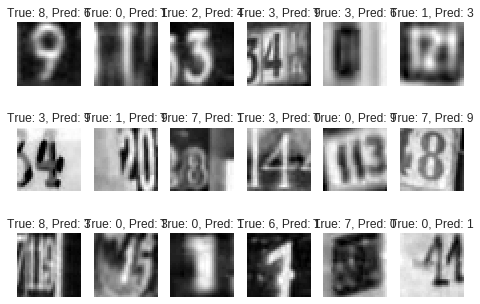

In [0]:
incorrect = test_pred != np.argmax(test_labels, axis=1)
print(test_pred)
temp = test_data_img


# Select the incorrectly classified examples
images = temp[incorrect]
cls_true = test_labels[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred)

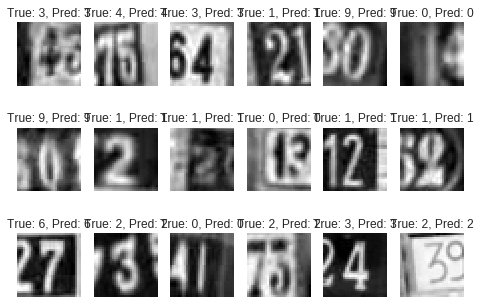

In [0]:
correct = np.invert(incorrect)

# Select the correctly classified examples
images = temp[correct]
cls_true = test_labels[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred)

In [0]:
import seaborn as sns
from sklearn.metrics import  confusion_matrix

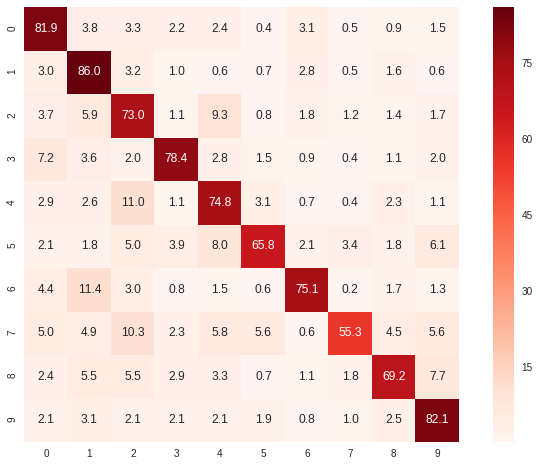

In [0]:
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(test_labels, axis=1), y_pred=test_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

###Method5---CNN

####introduction

####preprocessing

In [0]:
from scipy.io import loadmat as load
import numpy as np

In [0]:
train= load('./dataset/train_32x32.mat') # data is train['X'], label is train['y']
validation= load('./dataset/test_32x32.mat')

In [0]:
# 分割train_data 成 10个子样本
def seprate_data(data, K, type='data'):
    if type == 'data':
        number_of_training_data = data.shape[3]
        data = data.transpose((3, 0, 1, 2))

    else:
        number_of_training_data = data.shape[0]
        data = data.flatten()
        data[data == 10] = 0

    return data


train_data_t = seprate_data(train['X'], 10, type='data')
print('train_data_t的完整结构', train_data_t.shape)
train_labels_t = seprate_data(train['y'], 10, type='label')
# train_labels_t=np.array(train_labels_t)
print('train_labels_t的完整结构', np.shape(train_labels_t))

validation_data_t = seprate_data(validation['X'], 10, type='data')
print('train_data_t的完整结构', validation_data_t.shape)
validation_labels_t = seprate_data(validation['y'], 10, type='label')
# train_labels_t=np.array(train_labels_t)
print('train_labels_t的完整结构', np.shape(validation_labels_t))

train_data_t的完整结构 (73257, 32, 32, 3)
train_labels_t的完整结构 (73257,)
train_data_t的完整结构 (26032, 32, 32, 3)
train_labels_t的完整结构 (26032,)


In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
# Fit the OneHotEncoder
enc = OneHotEncoder().fit(train_labels_t.reshape(-1, 1))
validation_enc = OneHotEncoder().fit(validation_labels_t.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
train_labels_t = enc.transform(train_labels_t.reshape(-1, 1)).toarray()

validation_labels_t = validation_enc.transform(validation_labels_t.reshape(-1, 1)).toarray()

In [0]:
image_size = 32  
pixel_depth = 255.0  

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)

    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(np.array(train_data_t))[:,:,:,0]

validation_data_c = im2gray(np.array(validation_data_t))[:,:,:,0]

print('train_data_c的完整结构',train_data_c.shape)

train_data_c的完整结构 (73257, 32, 32)


In [0]:
def GCN(image, min_divisor=1e-4):
    """Global Contrast Normalization"""

    imsize = image.shape[0]
    mean = np.mean(image, axis=(1, 2), dtype=float)
    std = np.std(image, axis=(1, 2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)

    for i in np.arange(imsize):
        image_GCN[i, :, :] = (image[i, :, :] - mean[i]) / std[i]

    return image_GCN


train_data_GCN = GCN(train_data_c)

validation_data_GCN = GCN(validation_data_c)

print(train_data_GCN.shape, np.shape(train_labels_t))

(73257, 32, 32) (73257, 10)


In [0]:
def train_test_split_10(train_X, train_y, k):
    num_of_examples = len(train_X)
    start_jump = (num_of_examples // 10) * k
    end_jump = (num_of_examples // 10) * (k + 1)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(len(train_X)):
        if i <= start_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        elif i > end_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        else:
            X_test.append(train_X[i])
            y_test.append(train_y[i])

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train,  y_train,X_test, y_test

train_data_GCN,train_labels,test_data_GCN,test_labels=train_test_split_10(train_data_GCN, train_labels_t,0)
print(np.shape(train_data_GCN))
print(np.shape(train_labels))
print(np.shape(test_data_GCN))
print(np.shape(test_labels))
print(np.shape(validation_data_GCN))
print(np.shape(validation_labels_t))

(65932, 32, 32)
(65932, 10)
(7325, 32, 32)
(7325, 10)
(26032, 32, 32)
(26032, 10)


####machine learning technique

In [0]:
img_size = train_data_GCN.shape[1]

num_channels = 1

num_classes = train_labels.shape[1]

In [0]:

train_mean = np.mean(train_data_GCN, axis=0)


train_std = np.std(train_data_GCN, axis=0)


train_data_GCN = (train_data_GCN - train_mean) / train_std
test_data_GCN = (test_data_GCN - train_mean)  / train_std
validation_data_GCN = (validation_data_GCN - train_mean)  / train_std

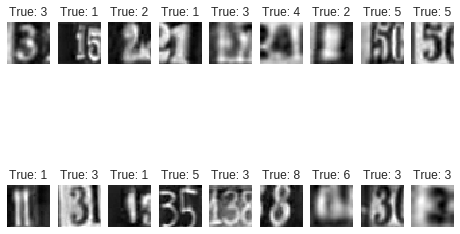

In [0]:
import matplotlib.pyplot as plt
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    fig, axes = plt.subplots(nrows, ncols)
    rs = np.random.choice(images.shape[0], nrows * ncols)
    for i, ax in zip(rs, axes.flat):
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
            else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])

        ax.imshow(images[i, :, :, 0], cmap='binary')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

temp=train_data_GCN.reshape(train_data_GCN.shape[0],train_data_GCN.shape[1],train_data_GCN.shape[2],1)
plot_images(temp, 2, 9, train_labels)

In [0]:
import tensorflow as tf

In [0]:
def conv_weight_variable(layer_name, shape):
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))

In [0]:
def conv_layer(input,  
               layer_name,  
               num_input_channels,  
               filter_size,  
               num_filters, 
               pooling=True):  

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = conv_weight_variable(layer_name, shape=shape)
    biases = bias_variable(shape=[num_filters])
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    layer = tf.nn.relu(layer)
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    return layer, weights


In [0]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [0]:
def fc_layer(input,        
             layer_name,   
             num_inputs,   
             num_outputs,  
             relu=True):   

    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])
    layer = tf.matmul(input, weights) + biases
    if relu:
        layer = tf.nn.relu(layer)

    return layer

In [0]:
# Convolutional Layer 1.
filter_size1 = 5          
num_filters1 = 32         
# Convolutional Layer 2.
filter_size2 = 5          
num_filters2 = 64         
# Fully-connected layer.
fc_size = 256 
# Number of training samples in each iteration
batch_size = 64
dropout = 0.5
total_iterations = 0

In [0]:
import os
import time
from datetime import timedelta

In [0]:
def train(train_data_GCN,train_labels,test_data_GCN,test_labels,validation_data_GCN,validation_labels_t,K):
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')
    train_data_GCN = train_data_GCN.reshape(train_data_GCN.shape[0], train_data_GCN.shape[1], train_data_GCN.shape[2],
                                            1)
    test_data_GCN = test_data_GCN.reshape(test_data_GCN.shape[0], test_data_GCN.shape[1], test_data_GCN.shape[2], 1)
    validation_data_GCN = validation_data_GCN.reshape(validation_data_GCN.shape[0], validation_data_GCN.shape[1],
                                                      validation_data_GCN.shape[2], 1)
    print(np.shape(train_data_GCN))

    y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

    y_true_cls = tf.argmax(y_true, dimension=1)

    keep_prob = tf.placeholder(tf.float32)

    #
    conv_1, w_c1 = conv_layer(input=x,
                              layer_name="conv_1",
                              num_input_channels=num_channels,
                              filter_size=filter_size1,
                              num_filters=num_filters1, pooling=True)

    conv_1
    #
    conv_2, w_c2 = conv_layer(input=conv_1,
                              layer_name="conv_2",
                              num_input_channels=num_filters1,
                              filter_size=filter_size2,
                              num_filters=num_filters2,
                              pooling=True)

    dropout = tf.nn.dropout(conv_2, keep_prob)

    dropout
    #
    layer_flat, num_features = flatten_layer(dropout)

    layer_flat
    #

    fc_1 = fc_layer(input=layer_flat,
                    layer_name="fc_1",
                    num_inputs=num_features,
                    num_outputs=fc_size,
                    relu=True)

    fc_1
    #
    fc_2 = fc_layer(input=fc_1,
                    layer_name="fc_2",
                    num_inputs=fc_size,
                    num_outputs=num_classes,
                    relu=False)

    fc_2
    #

    y_pred = tf.nn.softmax(fc_2)
    y_pred_cls = tf.argmax(y_pred, dimension=1)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

    global_step = tf.Variable(0)

    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost, global_step=global_step)

    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    saver = tf.train.Saver()
    save_dir = "./modelfor_" + str(K) + "/"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_path = os.path.join(save_dir, 'svhn_single_greyscale')
    with tf.Session() as sess:

        sess.run(tf.initialize_all_variables())

        #total_iterations = 0
        num_iterations = 50000
        display_step = 5000
        X_train = train_data_GCN
        y_train = train_labels
        X_test = test_data_GCN
        y_test = test_labels
        X_val = validation_data_GCN
        y_val = validation_labels_t

        global total_iterations
        
        start_time = time.time()
        for step in range(num_iterations):

            offset = (step * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = X_train[offset:(offset + batch_size), :, :, :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            #print(type(batch_data))
            #print(type(batch_labels))
            #print(type(dropout))
            dropout=0.5
            feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: dropout}
            sess.run(optimizer, feed_dict=feed_dict_train)

            if step % display_step == 0:
                batch_acc = sess.run(accuracy, feed_dict=feed_dict_train)
                print("Minibatch accuracy at step %d: %.4f" % (step, batch_acc))
                validation_acc = sess.run(accuracy, {x: X_test, y_true: y_test, keep_prob: 1.0})
                print("Validation accuracy: %.4f" % validation_acc)

        total_iterations += num_iterations
        time_diff = time.time() - start_time
        test_accuracy = sess.run(accuracy, {x: X_val, y_true: y_val, keep_prob: 1.0})

        print("Test accuracy: %.4f" % test_accuracy)
        print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
        saver.save(sess=sess, save_path=save_path)

        test_pred = sess.run(y_pred_cls, {x: validation_data_GCN, y_true: validation_labels_t, keep_prob: 1.0})
    return test_pred
     

In [0]:
test_pred=train(train_data_GCN,train_labels,test_data_GCN,test_labels,validation_data_GCN,validation_labels_t,0)


(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.2344
Validation accuracy: 0.1147
Minibatch accuracy at step 5000: 0.9531
Validation accuracy: 0.9222
Minibatch accuracy at step 10000: 0.9531
Validation accuracy: 0.9279
Minibatch accuracy at step 15000: 0.9844
Validation accuracy: 0.9300
Minibatch accuracy at step 20000: 1.0000
Validation accuracy: 0.9311
Minibatch accuracy at step 25000: 0.9844
Validation accuracy: 0.9305
Minibatch accuracy at step 30000: 1.0000
Validation accuracy: 0.9311
Minibatch accuracy at step 35000: 0.9688
Validation accuracy: 0.9356
Minibatch accuracy at step 40000: 1.0000
Validation accuracy: 0.9352
Minibatch accuracy at step 45000: 0.9844
Validation accuracy: 0.9352
Test accuracy: 0.9262
Time usage: 0:06:58


[5 2 1 ... 7 6 7]


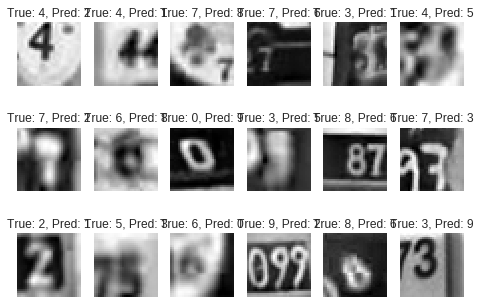

In [0]:
incorrect = test_pred != np.argmax(validation_labels_t, axis=1)
print(test_pred)
temp = validation_data_GCN.reshape(validation_data_GCN.shape[0],validation_data_GCN.shape[1],validation_data_GCN.shape[2],1)


# Select the incorrectly classified examples
images = temp[incorrect]
cls_true = validation_labels_t[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred)

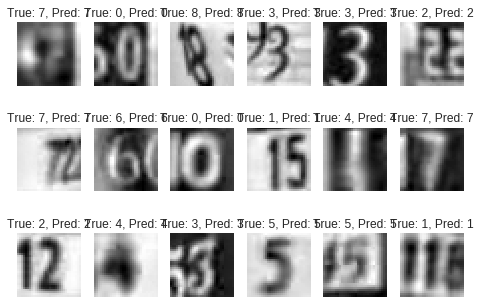

In [0]:
correct = np.invert(incorrect)

# Select the correctly classified examples
images = temp[correct]
cls_true = validation_labels_t[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred)

In [0]:
import seaborn as sns
from sklearn.metrics import  confusion_matrix

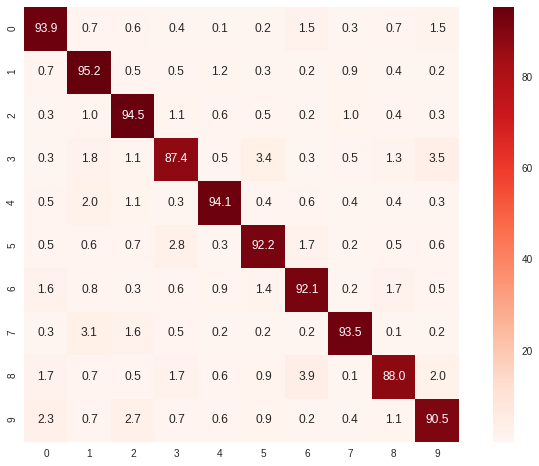

In [0]:
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(validation_labels_t, axis=1), y_pred=test_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

## Experiment

displays results and comparisons for the previously introduced methods. Include runtime, hardware and software specications of the computer that you used for performance evaluations. You are then expected to include meaningful comments on the results of your experiments, and reect on design choices.

## Conclusion

sum up your results and provide meaningful future work

## References

includes all references cited in your report, formatted in a
consistent way